<a href="https://colab.research.google.com/github/dasheng09/MJ/blob/main/Prompt_Similarity_vs_Esthetic_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0vrwx_8y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0vrwx_8y
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [44]:
import clip
print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [45]:
import torch
import clip
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14@336px", device=device)

In [46]:
import glob
file_list = glob.glob("/content/drive/MyDrive/AI/*/*.png")
file_list.sort()

In [47]:
print(file_list[96:96+12])

[]


In [48]:
from PIL import ImageFont, ImageDraw
fnt = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', 40)
dimensions = {"Abstract": (512, 512), "Landscape": (512, 512), "Portrait": (512, 512), 
          "Still Life": (512, 512), "Watercolor": (512, 512), "Character Design": (512, 512)}

for i, f in enumerate(file_list):
  if "v2" in f:
    sd = "V2"
  elif "v3" in f:
    sd = "V3"
  elif "v4" in f:
    sd = "V4"
  elif "v5" in f:
    sd = "V5"
  elif "niji4" in f:
    sd = "NIJI4"
  elif "niji5" in f:
    sd = "NIJI5"
  elif "niji expressive" in f:
    sd = "NIJI EX"
  elif "niji cute" in f:
    sd = "NIJI CU"
  else:
    sd = "SD"
  c = i%4

  print(f)
  parts = f.split("/")
  subject = parts[5]
  prompt = parts[3]
  dims = dimensions[subject]
  img = Image.open(f)
  img_resized = img.resize(dims)
  draw = ImageDraw.Draw(img_resized)

  if sd == "V2":
    draw.text((3, dims[1]-41), sd+str(c), font=fnt, fill=(255, 127, 14, 255))
  elif sd == "V3":
    draw.text((3, dims[1]-41), sd+str(c), font=fnt, fill=(31, 119, 180, 255))
  elif sd == "V4":
    draw.text((3, dims[1]-41), sd+str(c), font=fnt, fill=(44, 160, 44, 255))
  elif sd == "V5":
    draw.text((3, dims[1]-41), sd+str(c), font=fnt, fill=(255, 0, 0, 255))
  elif sd == "NIJI4":
    draw.text((3, dims[1]-41), sd+str(c), font=fnt, fill=(0, 255, 0, 255))
  elif sd == "NIJI5":
    draw.text((3, dims[1]-41), sd+str(c), font=fnt, fill=(0, 0, 255, 255))
  elif sd == "NIJI EX":
    draw.text((3, dims[1]-41), sd+str(c), font=fnt, fill=(255, 255, 0, 255))
  elif sd == "NIJI CU":
    draw.text((3, dims[1]-41), sd+str(c), font=fnt, fill=(255, 0, 255, 255))
  else:
    draw.text((3, dims[1]-41), sd+str(c), font=fnt, fill=(0, 0, 0, 255))

    draw.text((6, dims[1]-44), sd+str(c), font=fnt, fill=(255, 255, 255, 255)) 

  if c == 0:
    w = dims[0]*2+10
    h = dims[1]*2+10
    im = Image.new(mode = "RGB", size = (w, h), color = (255, 255, 255))
    Image.Image.paste(im, img_resized, (0, 0))

  elif c == 1:
    Image.Image.paste(im, img_resized, (dims[0]+10, 0))
  elif c == 2:
    Image.Image.paste(im, img_resized, (0, dims[1]+10))
  else:
    Image.Image.paste(im, img_resized, (dims[0]+10, dims[1]+10))
    im.save("/content/drive/MyDrive/AI"+subject+"/"+prompt+"_"+sd+".jpg", quality=95)

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


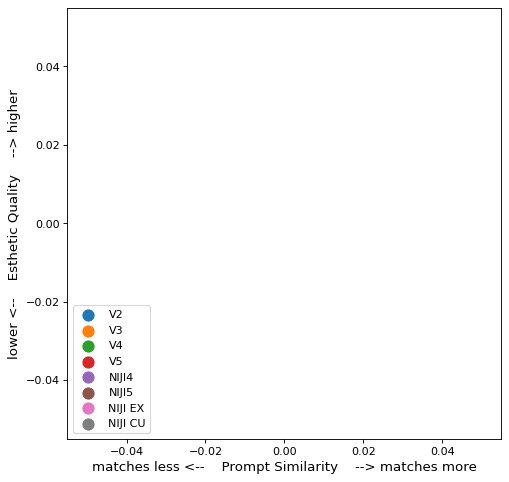

In [50]:
from IPython.display import display
prompt_similarities = []
esthetic_qualities = []
embeddings = []
labels = []

start = 96

for i, f in enumerate(file_list[start:start+12]):
  if "v2" in f:
    sd = "V2"
  elif "v3" in f:
    sd = "V3"
  elif "v4" in f:
    sd = "V4"
  elif "v5" in f:
    sd = "V5"
  elif "niji4" in f:
    sd = "NIJI4"
  elif "niji5" in f:
    sd = "NIJI5"
  elif "niji expressive" in f:
    sd = "NIJI EX"
  elif "niji cute" in f:
    sd = "NIJI CU"
  else:
    sd = "SD"
  c = i%4
  labels.append(sd+str(c))
  parts = f.split("/")
  subject = parts[5]
  prompt = parts[6]
  # print(sd, c, subject, prompt, f)

  img = Image.open(f)
  img_resized = img.resize((336, 336))
  # display(img_resized)

  image = preprocess(img_resized).unsqueeze(0).to(device)
  text = clip.tokenize(["fake art", "real art", "bad art", "good art", 
    prompt]).to(device)

  with torch.no_grad():
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    embeddings.append(image_features.flatten().cpu().tolist())
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

  fake = similarity[0][0]
  real = similarity[1][0]
  bad = similarity[2][0]
  good = similarity[3][0]
  esthetic_quality = (real-fake) + (good-bad)

  prompt_similarity = similarity[4][0]

  prompt_similarities.append(esthetic_quality)
  esthetic_qualities.append(prompt_similarity)

  print("{:7.4f}".format(prompt_similarity), "{:7.4f}".format(esthetic_quality), f)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 7), dpi=80)

plt.xlabel("matches less <--    Prompt Similarity    --> matches more", fontsize=12)
plt.ylabel("lower <--    Esthetic Quality    --> higher", fontsize=12)
plt.scatter(esthetic_qualities[8:12], prompt_similarities[8:12], s=100, label="V2")
plt.scatter(esthetic_qualities[4:8], prompt_similarities[4:8], s=100, label="V3")
plt.scatter(esthetic_qualities[0:4], prompt_similarities[0:4], s=100, label="V4")
plt.scatter(esthetic_qualities[12:16], prompt_similarities[12:16], s=100, label="V5")
plt.scatter(esthetic_qualities[16:20], prompt_similarities[16:20], s=100, label="NIJI4")
plt.scatter(esthetic_qualities[20:24], prompt_similarities[20:24], s=100, label="NIJI5")
plt.scatter(esthetic_qualities[24:28], prompt_similarities[24:28], s=100, label="NIJI EX")
plt.scatter(esthetic_qualities[28:32], prompt_similarities[28:32], s=100, label="NIJI CU")
plt.legend(loc="lower left")

for i, txt in enumerate(labels):
  ax.annotate(txt, (esthetic_qualities[i]+0.0009, prompt_similarities[i]-0.0003))
plt.show()